In [90]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import json
import numpy as np
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from scipy.stats import ttest_ind

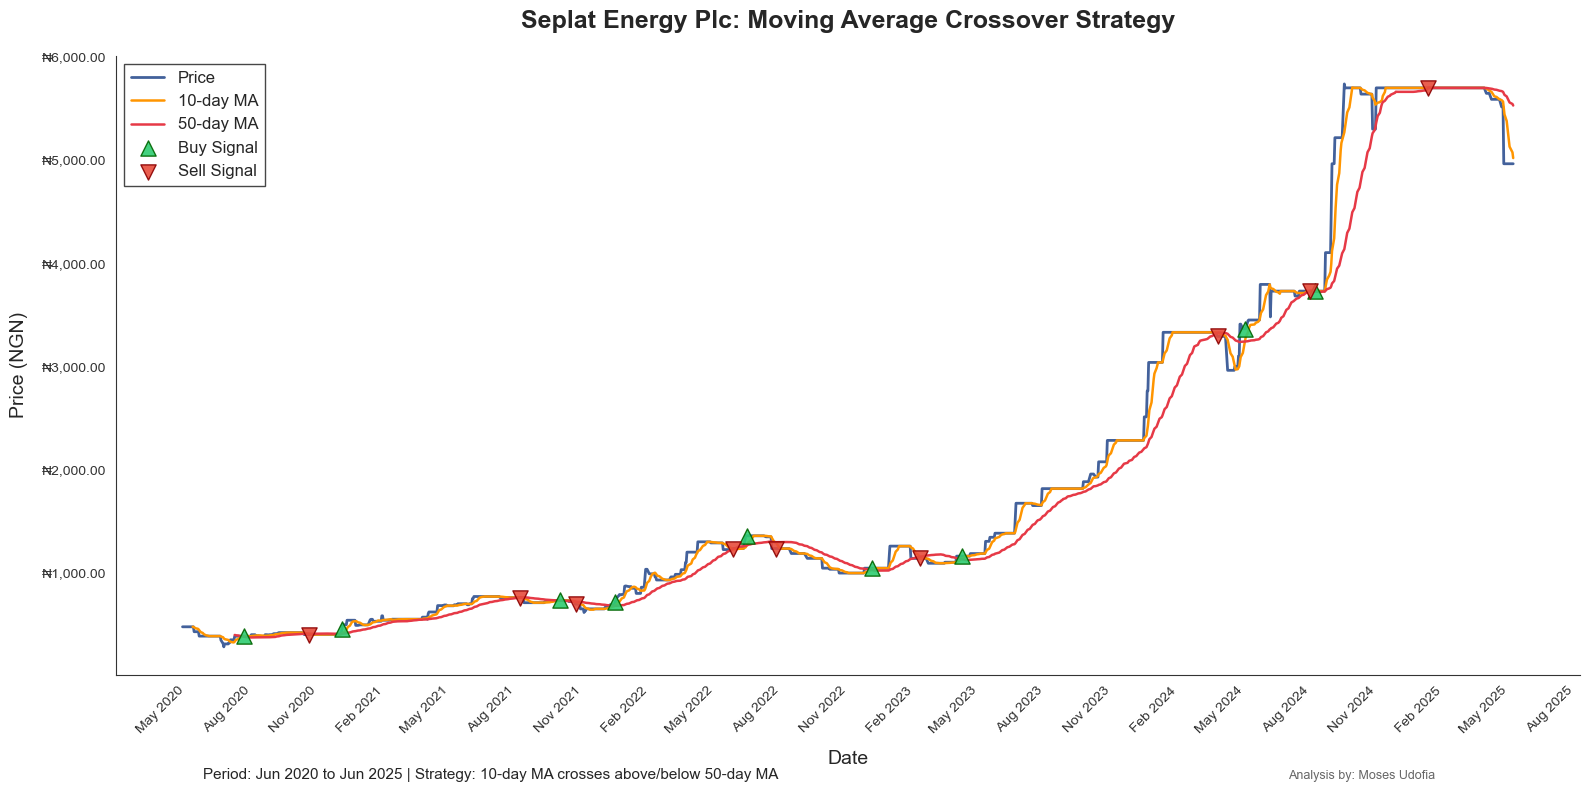

In [92]:
# === 1. Import Your CSV Data ===
file_path = r"C:\Users\moses\OneDrive\Desktop\Project Folder\Stock Data for Seplat NG 2020 - 2025.csv"
df = pd.read_csv(file_path, parse_dates=['Date']) 

# Convert 'Price' column to numeric after removing commas
df['Price'] = df['Price'].replace(',', '', regex=True).astype(float)

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

# Sort by date
df.sort_index(inplace=True)

# === 2. Calculate Moving Averages ===
df['MA10'] = df['Price'].rolling(window=10).mean()
df['MA50'] = df['Price'].rolling(window=50).mean()

# === 3. Generate Buy/Sell Signals ===
df['Signal'] = np.where(df['MA10'] > df['MA50'], 1, 0)
df['Position'] = df['Signal'].diff()

# === 4. Calculate Daily Returns ===
df['Returns'] = df['Price'].pct_change()
df['Strategy_Returns'] = df['Signal'].shift(1) * df['Returns']

# === 5. Create Professional Plot ===
# Set up the figure with a clean white background
plt.figure(figsize=(16, 8), facecolor='white')
ax = plt.subplot(1, 1, 1)
ax.set_facecolor('white')

# Format the y-axis to show currency
def naira_formatter(x, pos):
    return f'₦{x:,.2f}'

formatter = FuncFormatter(naira_formatter)
ax.yaxis.set_major_formatter(formatter)

# Plot price and moving averages with professional styling
ax.plot(df.index, df['Price'], label='Price', color='#2E5090', linewidth=2, alpha=0.9)
ax.plot(df.index, df['MA10'], label='10-day MA', color='#FF9500', linewidth=1.8)
ax.plot(df.index, df['MA50'], label='50-day MA', color='#E63946', linewidth=1.8)

# Add buy signals with improved styling
buy_signals = df[df['Position'] == 1]
ax.scatter(buy_signals.index, buy_signals['Price'], 
          marker='^', s=120, color='#2ECC71', edgecolors='darkgreen',
          label='Buy Signal', zorder=5, alpha=0.9)

# Add sell signals with improved styling
sell_signals = df[df['Position'] == -1]
ax.scatter(sell_signals.index, sell_signals['Price'], 
          marker='v', s=120, color='#E74C3C', edgecolors='darkred',
          label='Sell Signal', zorder=5, alpha=0.9)

# Remove grid lines
ax.grid(False)

# Remove top and right spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#333333')
ax.spines['bottom'].set_color('#333333')

# Format x-axis dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

# Add labels and title with professional styling
plt.title('Seplat Energy Plc: Moving Average Crossover Strategy', 
          fontsize=18, fontweight='bold', pad=20)
plt.ylabel('Price (NGN)', fontsize=14, labelpad=10)
plt.xlabel('Date', fontsize=14, labelpad=10)

# Create a professional legend
legend = plt.legend(loc='upper left', frameon=True, framealpha=0.9, 
                   fancybox=False, edgecolor='#333333', fontsize=12)
legend.get_frame().set_facecolor('white')

# Add company information and strategy description
start_date = df.index.min().strftime('%b %Y')
end_date = df.index.max().strftime('%b %Y')
plt.figtext(0.13, 0.02, 
           f"Period: {start_date} to {end_date} | Strategy: 10-day MA crosses above/below 50-day MA", 
           fontsize=11, ha='left')


# Add a subtle watermark
plt.figtext(0.9, 0.02, "Analysis by: Moses Udofia", 
           fontsize=9, alpha=0.7, ha='right')

# Adjust layout and display
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

In [82]:
# === 7. Monthly Resample for Performance Metrics ===

# Resample daily returns to monthly returns (compound returns within each month)
monthly_returns = df[['Strategy_Returns', 'Returns']].resample('ME').apply(lambda x: (1 + x).prod() - 1)
monthly_returns.rename(columns={'Returns': 'BuyHold_Returns'}, inplace=True)

# Calculate cumulative returns from monthly
cum_strategy = (1 + monthly_returns['Strategy_Returns']).cumprod()
cum_buyhold = (1 + monthly_returns['BuyHold_Returns']).cumprod()

# === 7. Define Performance Metric Functions ===

def sharpe_ratio(returns, risk_free_rate=0.0):
    excess = returns - risk_free_rate
    return np.mean(excess) / np.std(excess)

def annualized_volatility(returns, periods=12):  # Monthly → 12 months
    return np.std(returns) * np.sqrt(periods)

def max_drawdown(cumulative_returns):
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - peak) / peak
    return np.min(drawdown)

# === 9. Compute Metrics ===

strategy_returns = monthly_returns['Strategy_Returns'].dropna()
buyhold_returns = monthly_returns['BuyHold_Returns'].dropna()

metrics = {
    'Final Return (Strategy)': cum_strategy.iloc[-1] - 1,
    'Final Return (BuyHold)': cum_buyhold.iloc[-1] - 1,
    'Sharpe (Strategy)': sharpe_ratio(strategy_returns),
    'Sharpe (BuyHold)': sharpe_ratio(buyhold_returns),
    'Annual Volatility (Strategy)': annualized_volatility(strategy_returns),
    'Annual Volatility (BuyHold)': annualized_volatility(buyhold_returns),
    'Max Drawdown (Strategy)': max_drawdown(cum_strategy),
    'Max Drawdown (BuyHold)': max_drawdown(cum_buyhold)
}

# T-Test
t_stat, p_value = ttest_ind(strategy_returns, buyhold_returns, equal_var=False)
metrics['T-statistic'] = t_stat
metrics['P-value'] = p_value

# === 10. Display Results ===
print("\n📊 Monthly Performance Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")



📊 Monthly Performance Metrics:
Final Return (Strategy): 12.5906
Final Return (BuyHold): 9.4207
Sharpe (Strategy): 0.5014
Sharpe (BuyHold): 0.3880
Annual Volatility (Strategy): 0.3294
Annual Volatility (BuyHold): 0.4070
Max Drawdown (Strategy): -0.1299
Max Drawdown (BuyHold): -0.2660
T-statistic: 0.1076
P-value: 0.9145


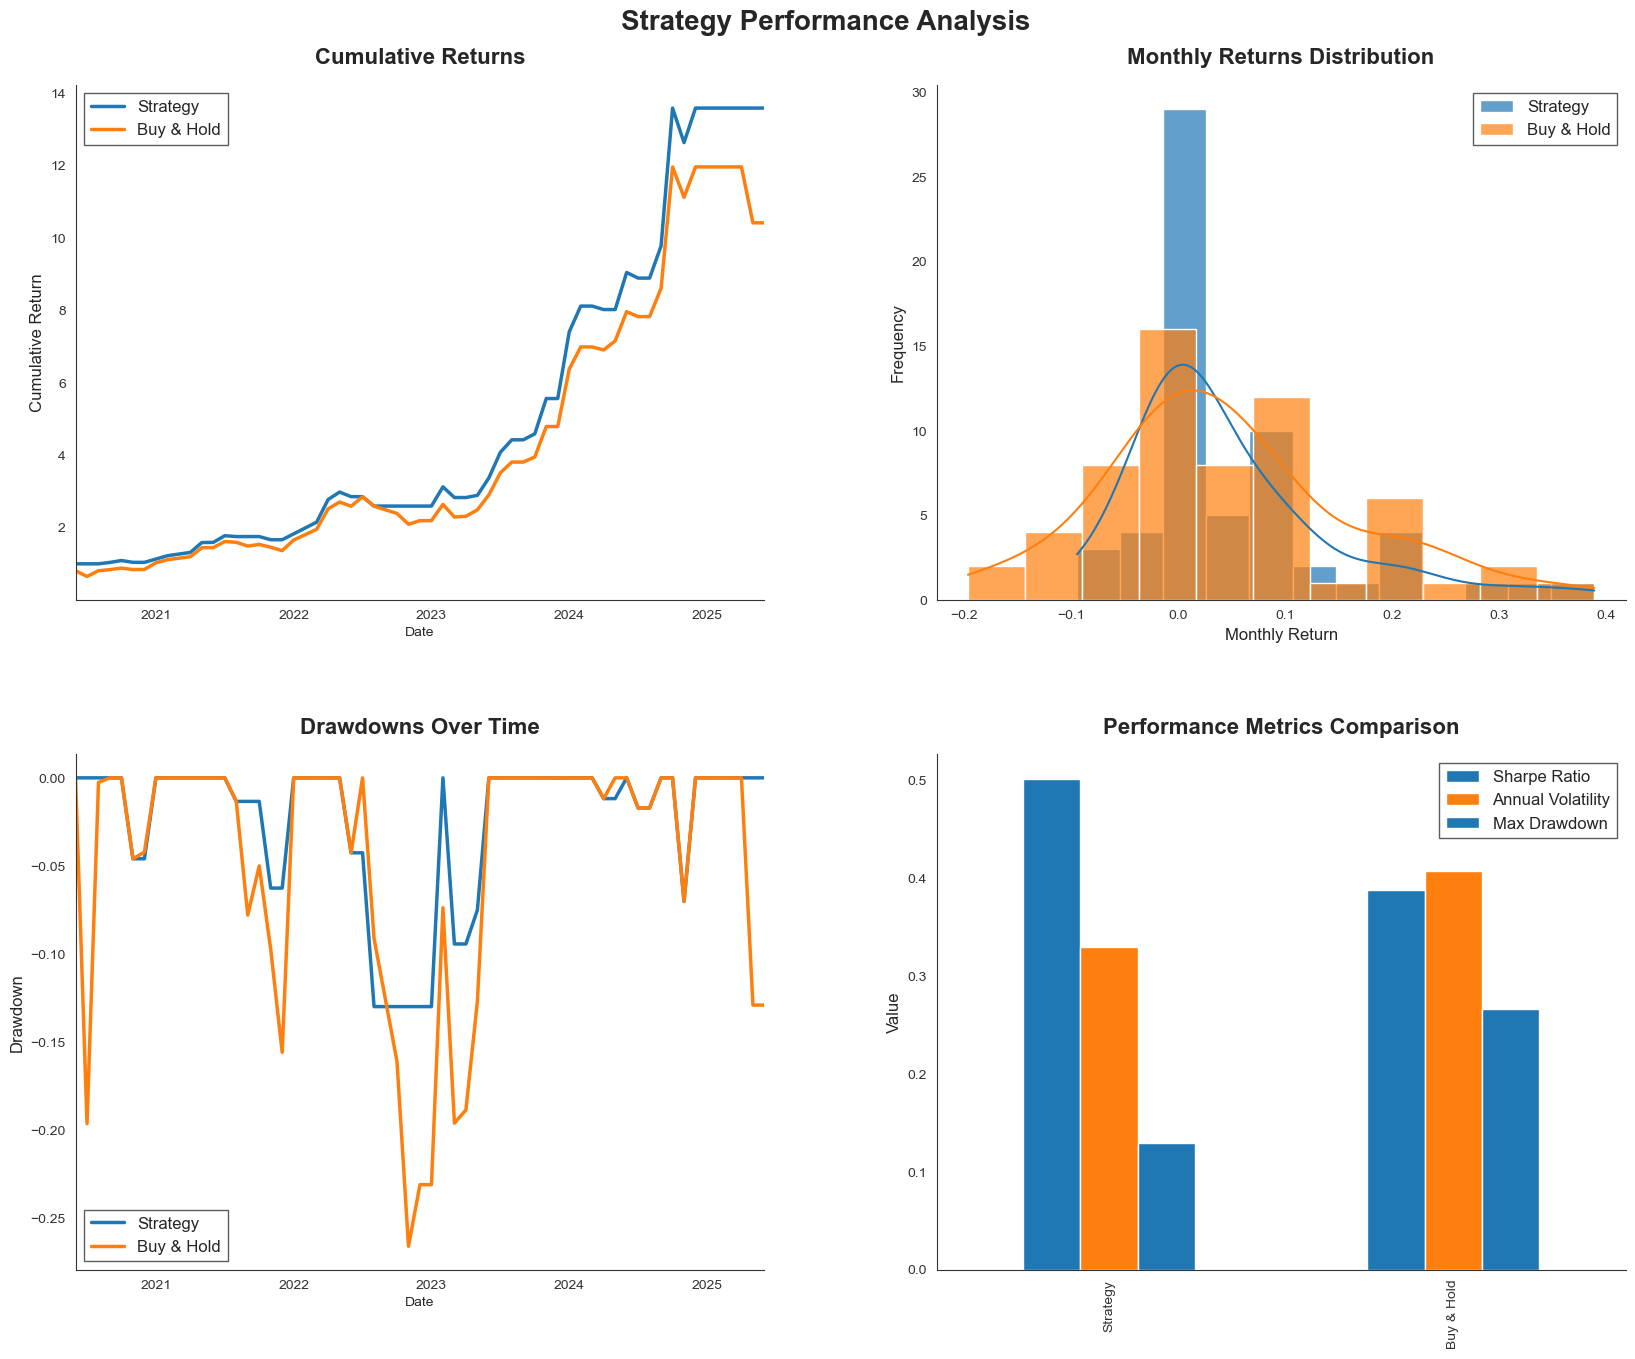

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [94]:
# Set the style for professional plots
plt.style.use('default')  # Reset to default style
sns.set_style("white")    # Clean white background
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['axes.edgecolor'] = '#333333'
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['xtick.color'] = '#333333'
plt.rcParams['ytick.color'] = '#333333'

# Color palette - professional blues and grays
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Create a figure with custom layout
fig = plt.figure(figsize=(20, 15), facecolor='white')
gs = GridSpec(2, 2, figure=fig)

# Cumulative Returns Plot
ax1 = fig.add_subplot(gs[0, 0])
cum_strategy.plot(ax=ax1, label='Strategy', color=colors[0], linewidth=2.5)
cum_buyhold.plot(ax=ax1, label='Buy & Hold', color=colors[1], linewidth=2.5)
ax1.set_title('Cumulative Returns', fontsize=16, fontweight='bold', pad=15)
ax1.set_ylabel('Cumulative Return', fontsize=12)
ax1.legend(frameon=True, fancybox=False, edgecolor='#333333', fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(False)

# Monthly Returns Distribution
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(strategy_returns, kde=True, color=colors[0], alpha=0.7, label='Strategy', ax=ax2)
sns.histplot(buyhold_returns, kde=True, color=colors[1], alpha=0.7, label='Buy & Hold', ax=ax2)
ax2.set_title('Monthly Returns Distribution', fontsize=16, fontweight='bold', pad=15)
ax2.set_xlabel('Monthly Return', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.legend(frameon=True, fancybox=False, edgecolor='#333333', fontsize=12)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(False)

# Drawdowns Over Time
ax3 = fig.add_subplot(gs[1, 0])
strategy_drawdown = (cum_strategy - cum_strategy.cummax()) / cum_strategy.cummax()
buyhold_drawdown = (cum_buyhold - cum_buyhold.cummax()) / cum_buyhold.cummax()
strategy_drawdown.plot(ax=ax3, label='Strategy', color=colors[0], linewidth=2.5)
buyhold_drawdown.plot(ax=ax3, label='Buy & Hold', color=colors[1], linewidth=2.5)
ax3.set_title('Drawdowns Over Time', fontsize=16, fontweight='bold', pad=15)
ax3.set_ylabel('Drawdown', fontsize=12)
ax3.legend(frameon=True, fancybox=False, edgecolor='#333333', fontsize=12)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.grid(False)

# Performance Metrics Comparison
ax4 = fig.add_subplot(gs[1, 1])
metrics_to_plot = {
    'Sharpe Ratio': [metrics['Sharpe (Strategy)'], metrics['Sharpe (BuyHold)']],
    'Annual Volatility': [metrics['Annual Volatility (Strategy)'], metrics['Annual Volatility (BuyHold)']],
    'Max Drawdown': [abs(metrics['Max Drawdown (Strategy)']), abs(metrics['Max Drawdown (BuyHold)'])]
}

metrics_df = pd.DataFrame(metrics_to_plot, index=['Strategy', 'Buy & Hold'])
metrics_df.plot(kind='bar', ax=ax4, color=[colors[0], colors[1]])
ax4.set_title('Performance Metrics Comparison', fontsize=16, fontweight='bold', pad=15)
ax4.set_ylabel('Value', fontsize=12)
ax4.legend(frameon=True, fancybox=False, edgecolor='#333333', fontsize=12)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.grid(False)

# Add a subtle title with professional styling
plt.suptitle('Strategy Performance Analysis', fontsize=20, fontweight='bold', y=0.95)
plt.subplots_adjust(top=0.90, wspace=0.25, hspace=0.3)

# Save the figure with high resolution
plt.savefig('strategy_performance_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')

# Display the figure
plt.show()

# Create a separate table visualization for the metrics with professional styling
plt.figure(figsize=(10, 6), facecolor='white')

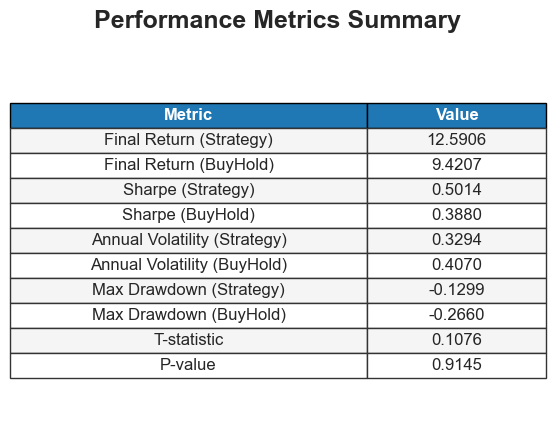

In [96]:
# Format the metrics for the table
metrics_table = pd.DataFrame({
    'Metric': list(metrics.keys()),
    'Value': list(metrics.values())
})

# Format the table for better readability
cell_text = []
for i in range(len(metrics_table)):
    if isinstance(metrics_table.iloc[i, 1], float):
        cell_text.append([metrics_table.iloc[i, 0], f"{metrics_table.iloc[i, 1]:.4f}"])
    else:
        cell_text.append([metrics_table.iloc[i, 0], metrics_table.iloc[i, 1]])

plt.axis('off')
table = plt.table(cellText=cell_text, colLabels=['Metric', 'Value'], 
                  loc='center', cellLoc='center', colWidths=[0.6, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)

# Style the table
for (row, col), cell in table.get_celld().items():
    if row == 0:  # Header row
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#1f77b4')
    else:
        cell.set_edgecolor('#333333')
        if row % 2:  # Alternating row colors for better readability
            cell.set_facecolor('#f5f5f5')
        else:
            cell.set_facecolor('white')

plt.title('Performance Metrics Summary', fontsize=18, fontweight='bold', pad=20)
plt.savefig('performance_metrics_table.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [98]:
import datetime

# Define parameters for bot configuration
bot_config = {
    "stock": "SEPLAT Plc",
    "moving_average_short": 10,
    "moving_average_long": 50,
    "start_date": datetime.date(2020, 1, 1),
    "end_date": datetime.date(2025, 1, 1),
    "initial_capital": 100000,  # NGN
    "transaction_fee": 0.001,   # 0.1% per trade
    "risk_free_rate": 0.03,     # 3% annualized
    "strategy": "MA Crossover with Buy/Sell Alerts",
    "frequency": "Monthly",
}

bot_config


{'stock': 'SEPLAT Plc',
 'moving_average_short': 10,
 'moving_average_long': 50,
 'start_date': datetime.date(2020, 1, 1),
 'end_date': datetime.date(2025, 1, 1),
 'initial_capital': 100000,
 'transaction_fee': 0.001,
 'risk_free_rate': 0.03,
 'strategy': 'MA Crossover with Buy/Sell Alerts',
 'frequency': 'Monthly'}